# PINN 튜토리얼: 공의 수직 투사 운동 예제 (Projectile Motion)

이 노트북은 **Physics-Informed Neural Networks (PINNs)** 의 개념을  
가장 단순한 역학적 시스템 중 하나인 **수직 투사 운동(Projectile Motion)** 에 적용해보는 실습 예제입니다.  

---

## 🎯 실험 목표
- **Data-only NN(데이터 기반 신경망)** 으로 공의 **상승 구간만 학습했을 때의 한계**를 확인합니다.  
- **PINN 구조**를 적용하여, **물리식을 손실 함수에 통합했을 때**  
  하강 구간까지 **일반화된 예측 성능**이 향상됨을 관찰합니다.

---

## 🧠 문제 설정
공이 수직으로 던져졌을 때, 시간에 따른 높이 \(y(t)\)는 다음 식으로 표현됩니다:

$$
y(t) \;=\; y_0 \;+\; v_0\, t \;-\; \frac{1}{2}\, g\, t^2
$$

- \(y_0\): 초기 높이 (initial position)  
- \(v_0\): 초기 속도 (initial velocity)  
- \(g\): 중력가속도 \(\approx 9.81\,\mathrm{m/s^2}\)

이 운동은 2차 미분방정식 형태의 단순한 **물리식(ODE)** 으로 표현할 수 있습니다:

$$
y''(t) \;+\; g \;=\; 0
$$

---

## 🔍 튜토리얼 구성

| 단계 | 내용 |
|------|------|
| **1️⃣ 데이터 생성** | 수직 투사 운동 데이터를 시뮬레이션하고, 상승 구간만 학습 데이터로 사용합니다. |
| **2️⃣ Data-only NN 학습** | 물리식을 고려하지 않고 단순 신경망으로 상승 구간만 학습합니다. |
| **3️⃣ PINN 학습** | 물리식 \( y'' + g = 0 \) 을 손실 함수에 포함시켜 전체 궤적을 학습합니다. |
---

> 💡 **핵심 아이디어**  
> PINN은 단순히 데이터를 회귀하는 모델이 아니라,  
> **물리 방정식(ODE/PDE)을 직접 학습 과정에 통합함으로써**  
> 데이터가 일부 구간에만 존재하더라도  
> **물리적으로 일관된(Physically consistent)** 해를 얻을 수 있습니다.


# 1️⃣ 데이터 생성

이 단계에서는 **공의 수직 투사 운동 데이터를 시뮬레이션**하여,  
**상승 구간(정점 이전)** 데이터만 학습용으로 사용합니다.

즉, 공이 올라가는 동안의 궤적만 관측되고,  
하강 구간은 **비지도(미관측)** 상태로 남겨 둔 뒤,  
이후 PINN이 물리식을 이용해 하강 구간까지 복원할 수 있는지를 확인합니다.

---

### 📐 물리 모델 요약

- 중력가속도: \( g = 9.81 \, \mathrm{m/s^2} \)  
- 초기 높이: \( y_0 \)  
- 초기 속도: \( v_0 \)

정점 시각과 총 비행시간은 다음과 같습니다.

$$
t_{\mathrm{apex}} = \frac{v_0}{g}, \qquad
t_{\mathrm{flight}} = \frac{2v_0}{g}.
$$

전체(평가) 궤적은 구간 \( [0,\, t_{\mathrm{flight}}] \)에서 균등 샘플링하며,

$$
y_{\mathrm{true}}(t) = y_0 + v_0 t - \tfrac{1}{2} g t^2
$$

로 계산됩니다.

---

### 🧪 데이터 구성

- **평가 데이터**: \(t_{\mathrm{eval}} \in [0,\, t_{\mathrm{flight}}]\)  
  → 참값 곡선 \(y_{\mathrm{true}}(t)\) 계산  
- **학습 데이터**: \(t_{\mathrm{train}} \in [0,\, t_{\mathrm{apex}} - \varepsilon]\)  
  → 상승 구간만 사용, 소량의 노이즈 포함  

$$
y_{\mathrm{train}}(t_i)
=
y_{\mathrm{true}}(t_i)
+
\mathcal{N}(0,\,\sigma^2)
$$

---

> ⚡ **핵심 포인트**  
> - 학습 데이터는 **상승 구간만 포함**하므로, 정보가 불완전합니다.  
> - **Data-only NN**은 하강 구간을 예측하지 못하지만,  
> - **PINN**은 물리식 제약 덕분에 하강 구간까지 일반화된 예측을 수행합니다.


PyTorch: 2.5.1 | CUDA available: True
[INFO] Apex time: 1.223 s
[INFO] Flight time: 2.446 s
[INFO] Training samples (upward only): 40


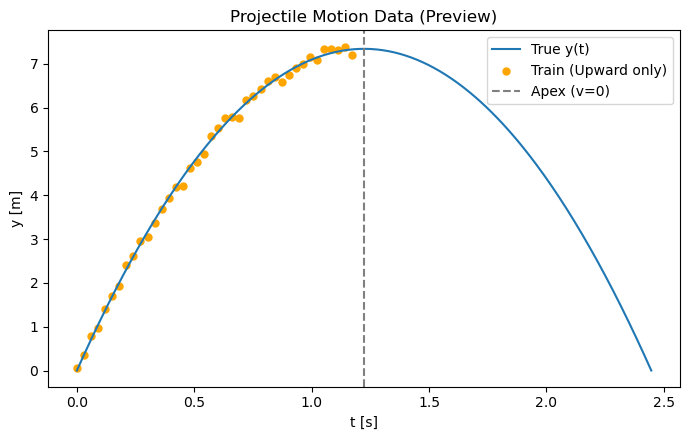

In [2]:
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt

print('PyTorch:', torch.__version__, '| CUDA available:', torch.cuda.is_available())
# 데이터 생성 + 시각화 (학습 전 미리보기용)
def make_projectile_data(g=9.81, y0=0.0, v0=12.0, noise=0.1, n_eval=300, n_train=40, show_plot=True):
    """
    공의 수직 운동 데이터를 생성하고, 옵션에 따라 시각화까지 수행하는 함수.
    상승 구간 데이터만 반환 (PINN 학습용).
    """
    t_flight = 2.0 * v0 / g
    t_apex   = v0 / g

    # 전체 구간 진실 궤적
    t_eval = np.linspace(0.0, t_flight, n_eval)
    y_true = y0 + v0*t_eval - 0.5*g*(t_eval**2)

    # 상승 구간 학습 데이터
    t_train = np.linspace(0.0, max(t_apex - 0.05, 0.01), n_train)
    y_train = y0 + v0*t_train - 0.5*g*(t_train**2) + np.random.randn(n_train)*noise

    if show_plot:
        print(f"[INFO] Apex time: {t_apex:.3f} s")
        print(f"[INFO] Flight time: {t_flight:.3f} s")
        print(f"[INFO] Training samples (upward only): {len(t_train)}")

        plt.figure(figsize=(7,4.5))
        plt.title("Projectile Motion Data (Preview)")
        plt.plot(t_eval, y_true, label="True y(t)")
        plt.scatter(t_train, y_train, s=25, color="orange", label="Train (Upward only)")
        plt.axvline(t_apex, ls="--", c="gray", label="Apex (v=0)")
        plt.xlabel("t [s]"); plt.ylabel("y [m]")
        plt.legend(); plt.tight_layout()
        plt.show()

    return (t_flight, t_apex, t_eval, y_true, t_train, y_train)

# 호출해서 바로 데이터 미리보기
t_flight, t_apex, t_eval, y_true, t_train, y_train = make_projectile_data()


# 2️⃣ Data-only NN 학습

이 단계에서는 **물리식 정보를 전혀 사용하지 않는** 순수 신경망(Regression)으로  
상승 구간 데이터만을 학습합니다. 목표는 관측값을 잘 맞추는 것이며, **물리적 일관성은 고려하지 않습니다.**

---

### 📌 학습 목표 (데이터 손실)
관측된 \((t_i, y_i)\)에 대해 평균제곱오차(MSE)를 최소화합니다.

$$
\mathcal{L}_{\mathrm{data}}
=
\frac{1}{N}\sum_{i=1}^{N}
\big(y_\theta(t_i) - y_i\big)^2
$$

여기서 \(y_\theta(t)\)는 신경망의 출력(예측)입니다.

---

### 🧱 모델 구조 (예)
- 입력: \(t \in \mathbb{R}\)
- 출력: \(y(t) \in \mathbb{R}\)
- MLP (예: \(\text{Linear} \rightarrow \tanh \rightarrow \text{Linear} \rightarrow \tanh \rightarrow \text{Linear}\))

---

### 🔧 학습 절차
1. 상승 구간 학습 데이터 \( (t_{\mathrm{train}},\, y_{\mathrm{train}}) \) 준비  
2. 옵티마이저(Adam)와 학습률 설정 (예: \( 1 \times 10^{-3} \))  
3. \( E \) epoch 동안 데이터 손실 \( \mathcal{L}_{\mathrm{data}} \) 최소화  
4. 학습 후, **전체 구간** \( t_{\mathrm{eval}} \)에서 예측 \( y_{\theta}(t) \)을 계산·시각화

데이터 손실(MSE)은 다음과 같습니다.

$$
\mathcal{L}_{\mathrm{data}}
=
\frac{1}{N}\sum_{i=1}^{N}
\big(y_{\theta}(t_i) - y_i\big)^2
$$

---


### 🔎 해석 포인트
- **장점**: 관측 구간(상승)에서의 적합도는 높을 수 있음  
- **한계**: 물리식 제약이 없으므로 **하강 구간 외삽**에서 곡률/형태를 잘못 예측할 가능성 큼  
- 다음 단계(§3 PINN)에서 **물리 잔차**를 추가하여 이 한계를 개선합니다.

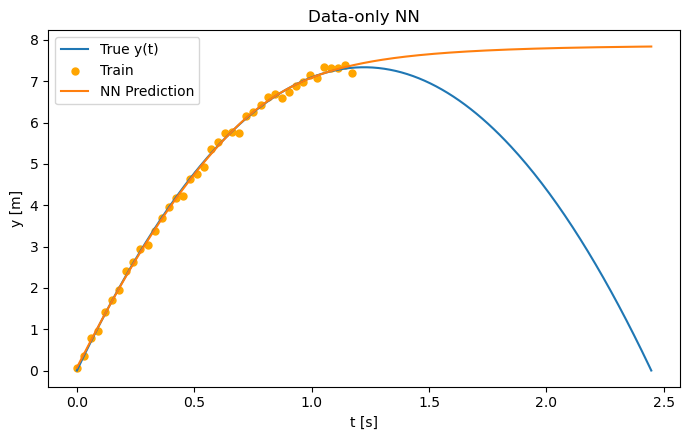

[Data-only NN] Full-trajectory MSE: 6.694371


In [3]:
class MLP(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, 1),
        )
    def forward(self, x): 
        return self.net(x)

def mse(a,b): 
    return torch.mean((a-b)**2)

# Data-only Neural Network 학습 및 결과 플롯
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model_data = MLP(h=64).to(device)
opt = optim.Adam(model_data.parameters(), lr=1e-3)

# 텐서 변환
t_train_t = torch.tensor(t_train, dtype=torch.float32, device=device).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device).unsqueeze(1)
t_eval_t  = torch.tensor(t_eval,  dtype=torch.float32, device=device).unsqueeze(1)
y_true_t  = torch.tensor(y_true,  dtype=torch.float32, device=device).unsqueeze(1)

# 학습 루프
EPOCHS = 5000
for ep in range(EPOCHS):
    opt.zero_grad()
    loss = mse(model_data(t_train_t), y_train_t)
    loss.backward()
    opt.step()

# 학습 후 결과 예측 및 시각화
with torch.no_grad():
    y_pred_data = model_data(t_eval_t).cpu().numpy().squeeze()

plt.figure(figsize=(7,4.5))
plt.title("Data-only NN")
plt.plot(t_eval, y_true, label="True y(t)")
plt.scatter(t_train, y_train, s=25, color="orange", label="Train")
plt.plot(t_eval, y_pred_data, label="NN Prediction")
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.legend(); plt.tight_layout()
plt.show()

print(f"[Data-only NN] Full-trajectory MSE: {mse(torch.tensor(y_pred_data), torch.tensor(y_true)).item():.6f}")


# 3️⃣ PINN 학습

이제 동일한 네트워크 구조를 사용하지만, **물리식을 손실 함수에 통합**하여  
상승·하강 구간을 모두 예측할 수 있도록 **Physics-Informed Neural Network (PINN)** 을 학습합니다.

---

### 📌 핵심 아이디어

PINN은 데이터 손실뿐 아니라, 물리식의 **잔차(residual)** 를 추가로 최소화합니다.  
공의 운동은 다음 2차 미분방정식으로 표현됩니다.

$$
y''(t) + g = 0
$$

이를 만족하도록 학습하기 위해, PINN의 총 손실은 다음과 같이 구성됩니다.

$$
\mathcal{L}_{\mathrm{total}}
=
\mathcal{L}_{\mathrm{data}}
+
\lambda_{\mathrm{phys}}\,\mathcal{L}_{\mathrm{phys}}
+
\lambda_{\mathrm{ic}}\,\mathcal{L}_{\mathrm{ic}}
$$

- **데이터 손실 (Data loss)**  
  $$
  \mathcal{L}_{\mathrm{data}}
  =
  \frac{1}{N}
  \sum_i
  \big(
  y_\theta(t_i)
  -
  y_i
  \big)^2
  $$

- **물리 잔차 손실 (Physics residual loss)**  
  PINN은 \( y''(t) + g = 0 \) 을 직접 만족하도록 훈련됩니다.
  $$
  \mathcal{L}_{\mathrm{phys}}
  =
  \frac{1}{M}
  \sum_c
  \big(
  y''_\theta(t_c)
  +
  g
  \big)^2
  $$

- **초기조건 손실 (Initial condition loss)**  
  \( y(0) = y_0, \; y'(0) = v_0 \) 제약을 추가합니다.
  $$
  \mathcal{L}_{\mathrm{ic}}
  =
  (y_\theta(0) - y_0)^2
  +
  (y'_\theta(0) - v_0)^2
  $$

---



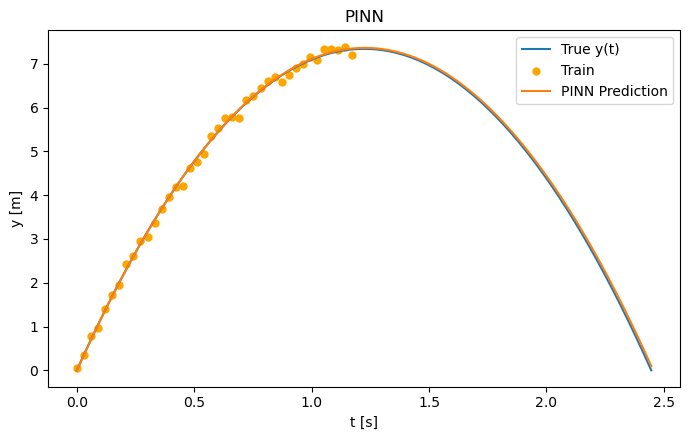

[PINN] Full-trajectory MSE: 0.001707


In [4]:
# PINN 학습 및 결과 플롯
def residual(model, t_in, g=9.81):
    t_in = t_in.requires_grad_(True)
    y    = model(t_in)
    dy   = grad(y, t_in, torch.ones_like(y), create_graph=True)[0]
    d2y  = grad(dy, t_in, torch.ones_like(dy), create_graph=True)[0]
    return d2y + g

model_pinn = MLP(h=64).to(device)
opt = optim.Adam(model_pinn.parameters(), lr=2e-3)

t_col = torch.linspace(0.0, t_eval[-1], 400, device=device).unsqueeze(1).requires_grad_(True)
t0 = torch.zeros((1,1), dtype=torch.float32, device=device, requires_grad=True)
y0_t = torch.tensor([[0.0]], dtype=torch.float32, device=device)
v0_t = torch.tensor([[12.0]], dtype=torch.float32, device=device)

EPOCHS = 5000
for ep in range(EPOCHS):
    opt.zero_grad()
    loss_data = mse(model_pinn(t_train_t), y_train_t)
    f = residual(model_pinn, t_col, g=9.81)
    loss_phys = mse(f, torch.zeros_like(f))
    y0_pred = model_pinn(t0)
    dy0 = grad(y0_pred, t0, torch.ones_like(y0_pred), create_graph=True)[0]
    loss_ic = mse(y0_pred, y0_t) + mse(dy0, v0_t)
    loss = loss_data + loss_phys + loss_ic
    loss.backward()
    opt.step()

# 학습 후 결과 예측 및 시각화
with torch.no_grad():
    y_pred_pinn = model_pinn(t_eval_t).cpu().numpy().squeeze()

plt.figure(figsize=(7,4.5))
plt.title("PINN")
plt.plot(t_eval, y_true, label="True y(t)")
plt.scatter(t_train, y_train, s=25, color="orange", label="Train")
plt.plot(t_eval, y_pred_pinn, label="PINN Prediction")
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.legend(); plt.tight_layout()
plt.show()

print(f"[PINN] Full-trajectory MSE: {mse(torch.tensor(y_pred_pinn), torch.tensor(y_true)).item():.6f}")


## 결론
- **Data-only NN**은 상승 구간엔 잘 맞지만 하강 외삽 실패  
- **PINN**은 물리 잔차($y''+g=0$)와 초기조건으로 전 구간 일반화